**This is not a real assignment for CSCB! It's just a realistic example to demonstrate the style guide.** 


### Organization

After the usual imports, we follow the order as described in the assignment, except that out of convenience, some QC metrics are computed before the data reshaping is done.

In [7]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import anndata
from IPython.display import display, HTML

# Import the code provided with the assignment
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

# visualization settings
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Some useful gene annotation files
geneAnnotationPath = "../accessory_data/gencode.v35.annotation.gtf.gz"       # Downloaded from https://www.gencodegenes.org/human/release_35.html
cellcycleGenePath = "../accessory_data/regev_lab_cell_cycle_genes.txt"




### 1. Tidy the dataset so that it fits in an AnnData object. 


In [8]:
# Reading from .mtx is slow, so we memoize to h5ad. 
dataset_name = "replogle"
if not os.path.exists(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip"):
    expression_quantified = sc.read_10x_mtx(f"not_ready/{dataset_name}/GSM4367986_exp8/")
    expression_quantified.write_h5ad(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip", compression="gzip")
else:
    expression_quantified = sc.read_h5ad(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip")

In [9]:
# Typical reshaping of data and computation of QC metrics
sc.pp.calculate_qc_metrics(expression_quantified, inplace = True)
cell_metadata = pd.read_csv(f"not_ready/{dataset_name}/GSM4367986_exp8/cell_identities.csv.gz")
cell_metadata.index = cell_metadata["cell_barcode"]
cell_metadata["target_symbol"] = ingestion.convert_ens_to_symbol(
    cell_metadata["target"], 
    gtf=geneAnnotationPath, 
    strip_version = True)
expression_quantified.obs = pd.merge(expression_quantified.obs,
                                     cell_metadata, 
                                     how = "left", 
                                     left_index = True, 
                                     right_index = True)

expression_quantified.obs["has_guide_annotations"] = pd.notnull(expression_quantified.obs["coverage"]).astype("int")
expression_quantified.obs["good_coverage"] = expression_quantified.obs["good_coverage"].astype("str")
expression_quantified.raw = expression_quantified.copy()

In [10]:
expression_quantified = expression_quantified[~expression_quantified.obs.target_symbol.isna(), :]

In [11]:
expression_quantified.var_names = ingestion.convert_ens_to_symbol(
    expression_quantified.var_names, 
    gtf=geneAnnotationPath, 
)
display(expression_quantified.var.head())
display(expression_quantified.var_names[0:5])

,gene_ids,feature_types,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
RP11-34P13.3,ENSG00000243485,Gene Expression,14,0.000127,0.000127,99.987326,14.0,2.708050
FAM138A,ENSG00000237613,Gene Expression,0,0.000000,0.000000,100.000000,0.0,0.000000
OR4F5,ENSG00000186092,Gene Expression,0,0.000000,0.000000,100.000000,0.0,0.000000
RP11-34P13.7,ENSG00000238009,Gene Expression,343,0.003105,0.003100,99.689486,343.0,5.840641
RP11-34P13.8,ENSG00000239945,Gene Expression,55,0.000498,0.000498,99.950209,55.0,4.025352


Index(['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8'], dtype='object')

### 1.1 For each overexpressed gene, how many cells are measured?

The code below shows that between 212 and 1861 cells are measured for any given perturbation, with ~5k controls. 

In [13]:
n_cells_per_target = expression_quantified.obs.groupby("target_symbol")[["cell_barcode"]].count().sort_values("cell_barcode")
n_cells_per_target.columns = ["n_cells"]
n_cells_per_target.reset_index(inplace = True)
display(n_cells_per_target)
plt.rcParams['figure.figsize'] = [6, 9]

,target_symbol,n_cells
0,CEBPB,212
1,LHX4,238
2,PTPN1,284
3,CDKN1B,303
4,TBX21,315
...,...,...
59,TTC6,1513
60,RPL30,1712
61,MTOR,1735
62,MAP2K3,1861


### 2. Compute typical scRNA quality metrics and filter out genes and cells as discussed in class.

For this particular project, we prefer to err on the side of discarding real cells rather than risking inclusion of empty droplets, doublets, or other artifacts in our analysis. Out of an abundance of caution, we remove droplets with especially high or low total counts, and we remove droplets with high fractions of RNA from mitochondrial RNA's, ribosomal protein subunit RNA's, or high-expressed RNA's. Please consult the code below for exact thresholds and numbers. 

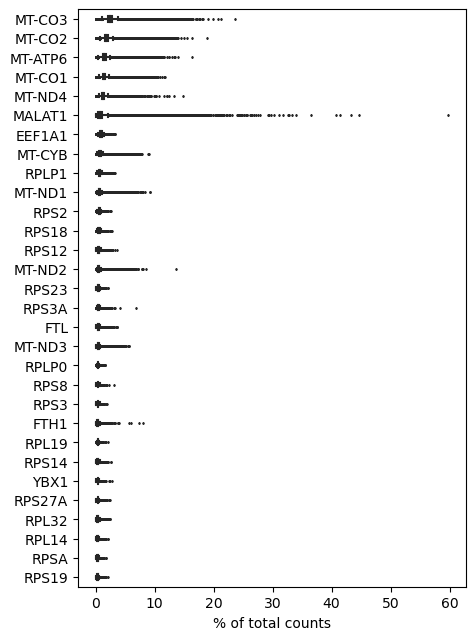

In [14]:
sc.pl.highest_expr_genes(expression_quantified, n_top=30, palette="Blues", width=.3)

In [15]:
expression_quantified.var['mt']   = expression_quantified.var_names.str.startswith(("MT-"))
expression_quantified.var['ribo'] = expression_quantified.var_names.str.startswith(("RPS","RPL"))
expression_quantified.var['mt'].sum(), expression_quantified.var['ribo'].sum(), 

(13, 103)

In [16]:
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

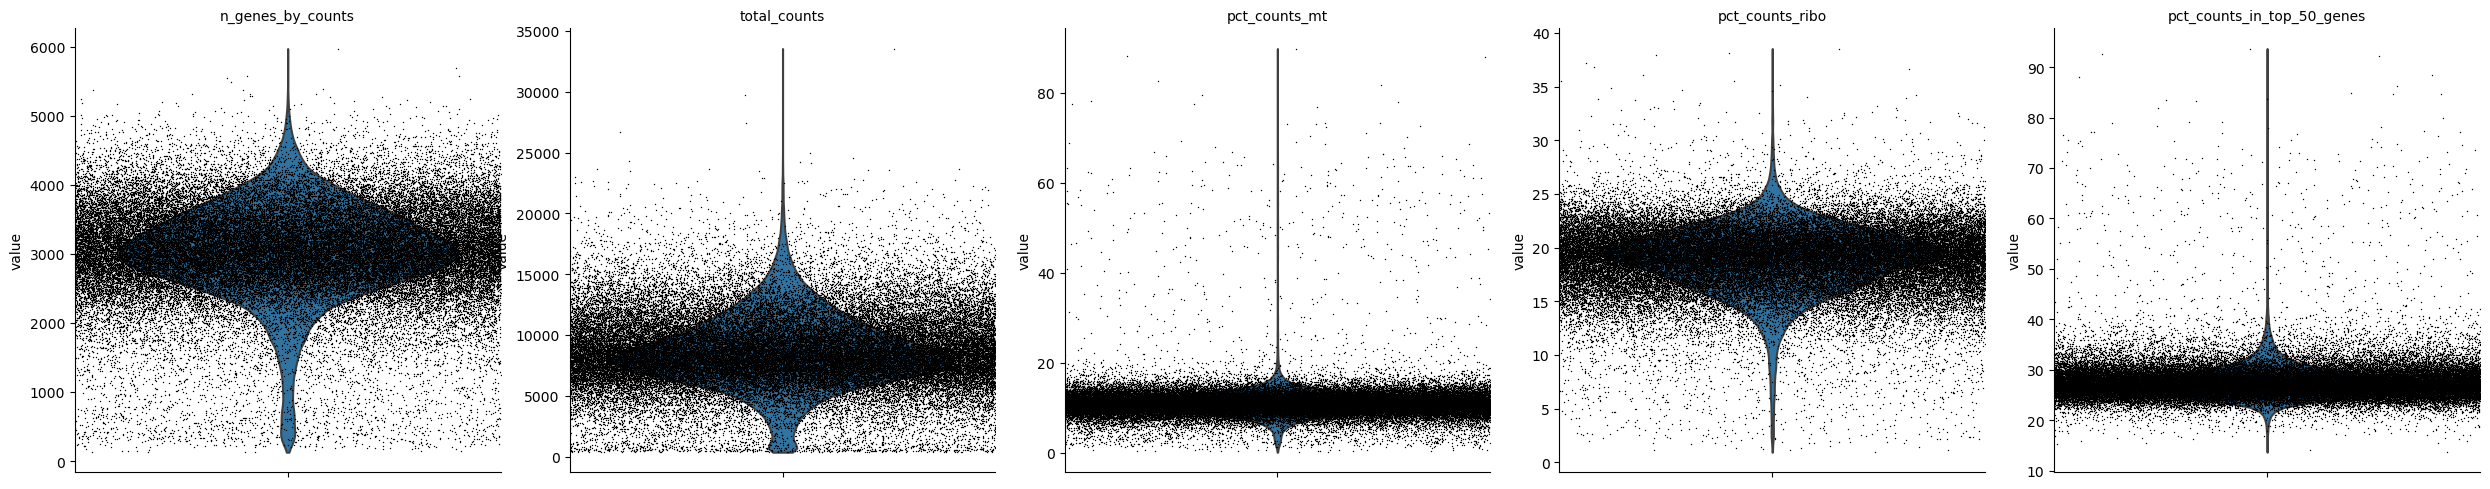

In [17]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.5, multi_panel=True)

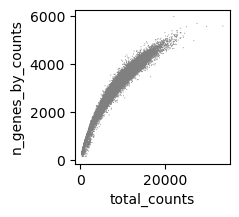

In [18]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

In [19]:
print("Number of cells: ", expression_quantified.n_obs)

# figure out the total counts == 95 percentile
thresh = np.percentile(expression_quantified.obs['total_counts'], 99)
print("99th percentile: ", thresh)

Number of cells:  60725
99th percentile:  17000.280000000006


In [20]:
expression_quantified = expression_quantified[expression_quantified.obs['total_counts'] < thresh, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  60117


In [21]:
expression_quantified = expression_quantified[expression_quantified.obs["total_counts"] >= 2000, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58809


In [22]:
expression_quantified = expression_quantified[expression_quantified.obs["pct_counts_in_top_50_genes"] <= 40, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58589


In [23]:
# filter for % mt
expression_quantified = expression_quantified[expression_quantified.obs['pct_counts_mt'] < 20, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58484


In [24]:
# filter for % ribo > 50%
expression_quantified = expression_quantified[expression_quantified.obs['pct_counts_ribo'] < 30, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58415


In [25]:
""" To verify the outcome of filtering cells """
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

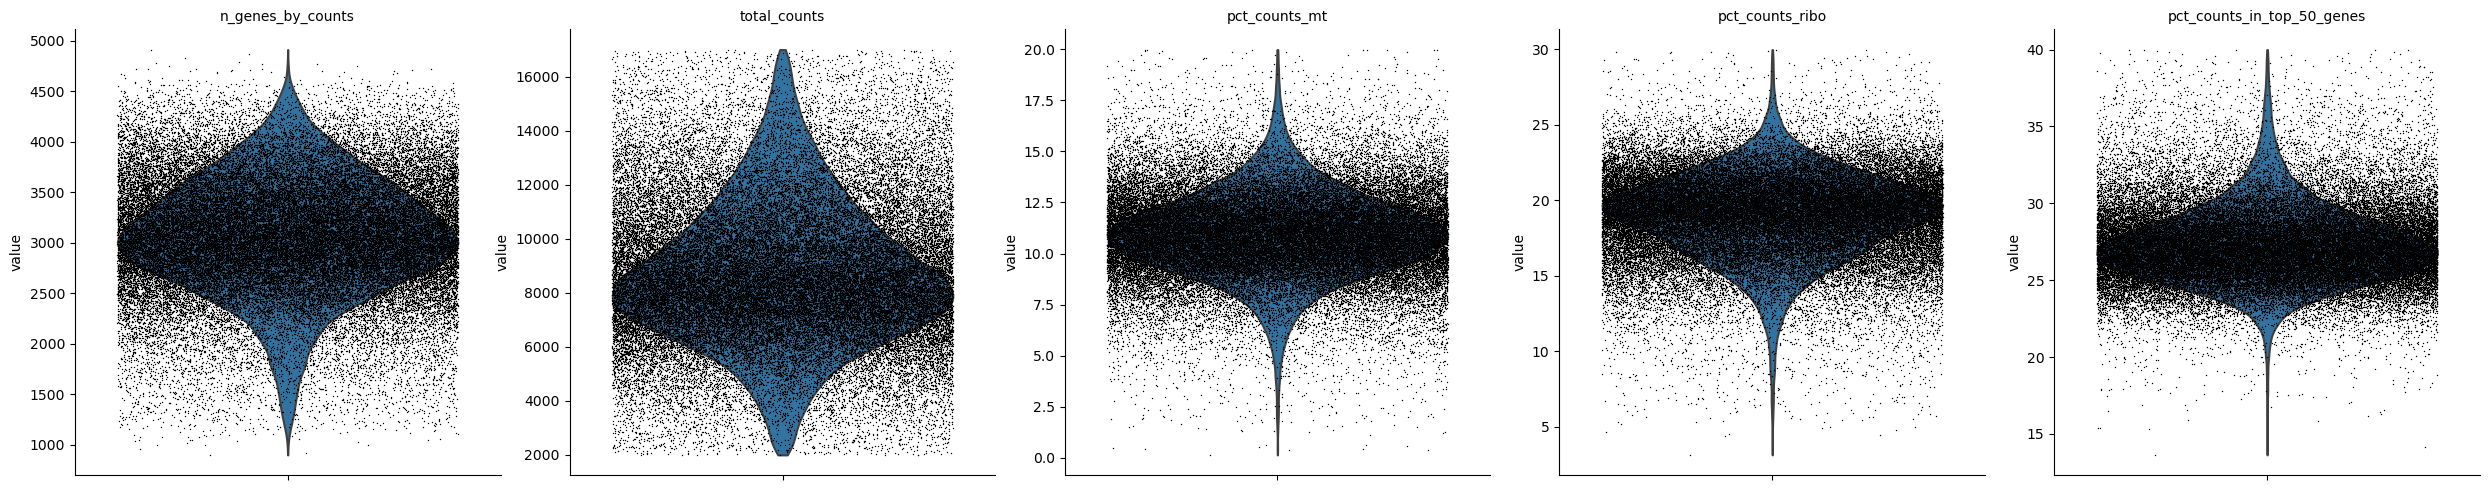

In [26]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.4, multi_panel=True)

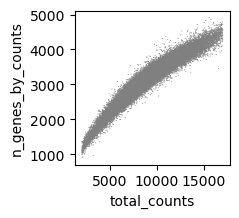

In [27]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

In [28]:
print("Number of genes: ", expression_quantified.n_vars)
gThresh = 10

sc.pp.filter_genes(expression_quantified, min_cells=gThresh)
print("Number of genes: ", expression_quantified.n_vars)

Number of genes:  33694
Number of genes:  18811


In [30]:
mito_genes = expression_quantified.var_names.str.startswith('MT-')
ribo_genes = expression_quantified.var_names.str.startswith(("RPL","RPS"))
malat_gene = expression_quantified.var_names.str.startswith("MALAT1")

In [32]:
remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, malat_gene)
keep = np.invert(remove)
expression_quantified = expression_quantified[:,keep].copy()
print("Number of genes: ", expression_quantified.n_vars)

Number of genes:  18700


In [33]:
[idx for idx, n in enumerate(expression_quantified.var.index) if n.upper() == 'GAPDH']

[11180]

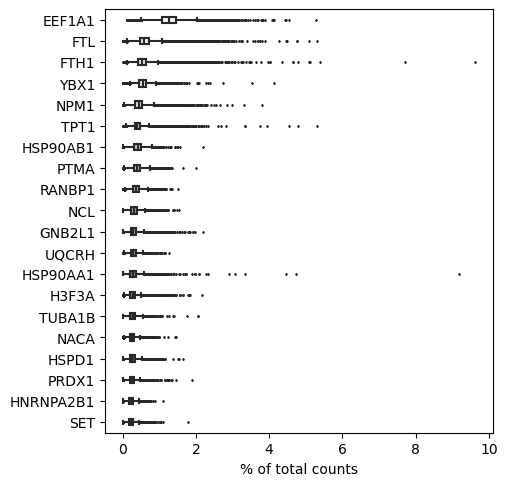

In [34]:
sc.pl.highest_expr_genes(expression_quantified, n_top=20, palette="Blues", width=.3)

In [35]:
""" To verify the outcome of filtering genes """
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

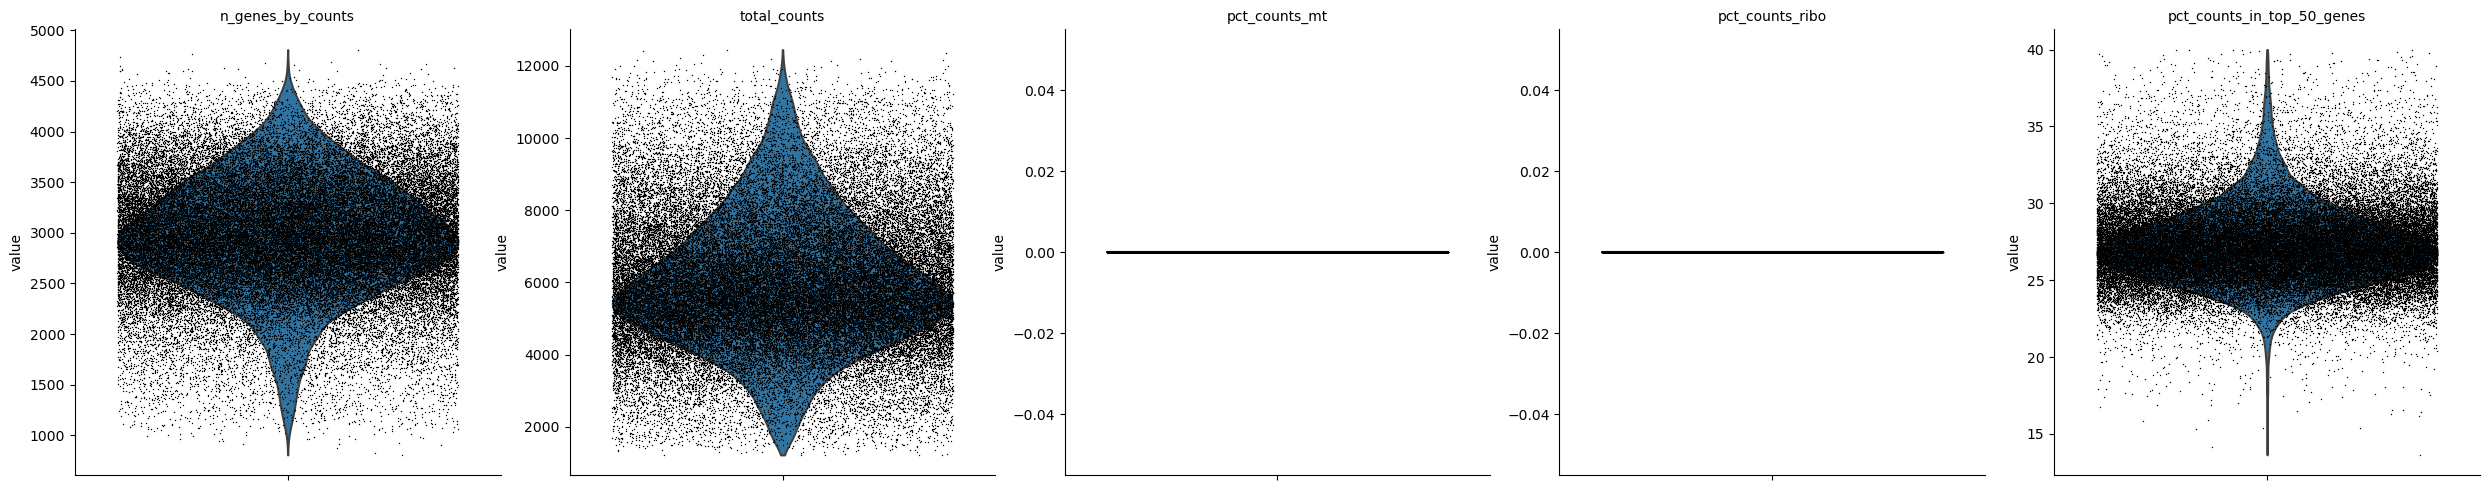

In [36]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.4, multi_panel=True)

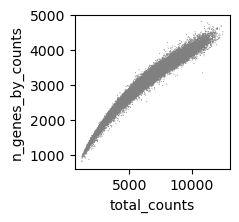

In [37]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

### Basic EDA 

Visualize the data using scanpy.

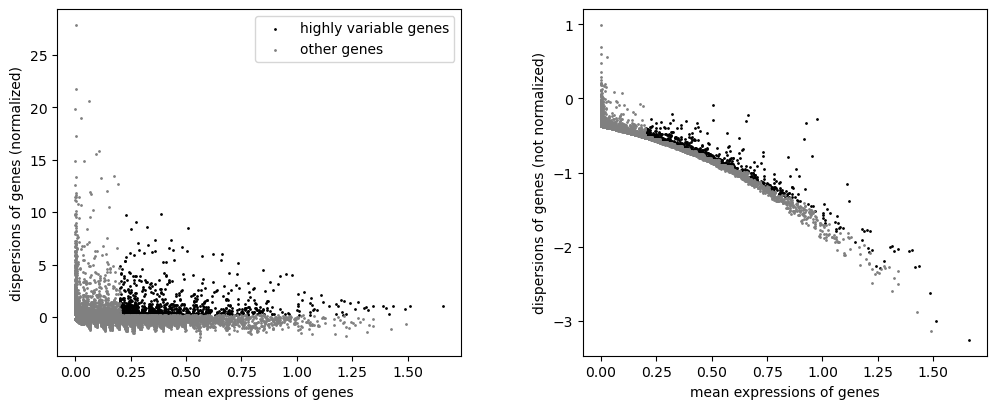

In [44]:
sc.pp.log1p(expression_quantified)
sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=100)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []
sc.tl.leiden(expression_quantified)
cc_genes = pd.read_csv(cellcycleGenePath, header = None)[0]
sc.tl.score_genes_cell_cycle(expression_quantified, s_genes=cc_genes[:43], g2m_genes=cc_genes[43:])
plt.rcParams['figure.figsize'] = [6, 4.5]


Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'cell_barcode', 'guide_identity',
       'num_guides', 'gene', 'best_gamma', 'correction', 'distance', 'gamma_A',
       'gamma_B', 'gene_type', 'protospacer_A', 'protospacer_B', 'rank_A',
       'rank_B', 'sgID_A', 'sgID_B', 'type', 'target', 'umi_A', 'umi_B',
       'read_count', 'UMI_count', 'coverage', 'good_coverage',
       'number_of_cells', 'gemgroup', 'target_symbol', 'has_guide_annotations',
       'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt',
       'pct_counts_mt', 'leiden', 'S_score', 'G2M_score', 'phase'],
      dtype='object')


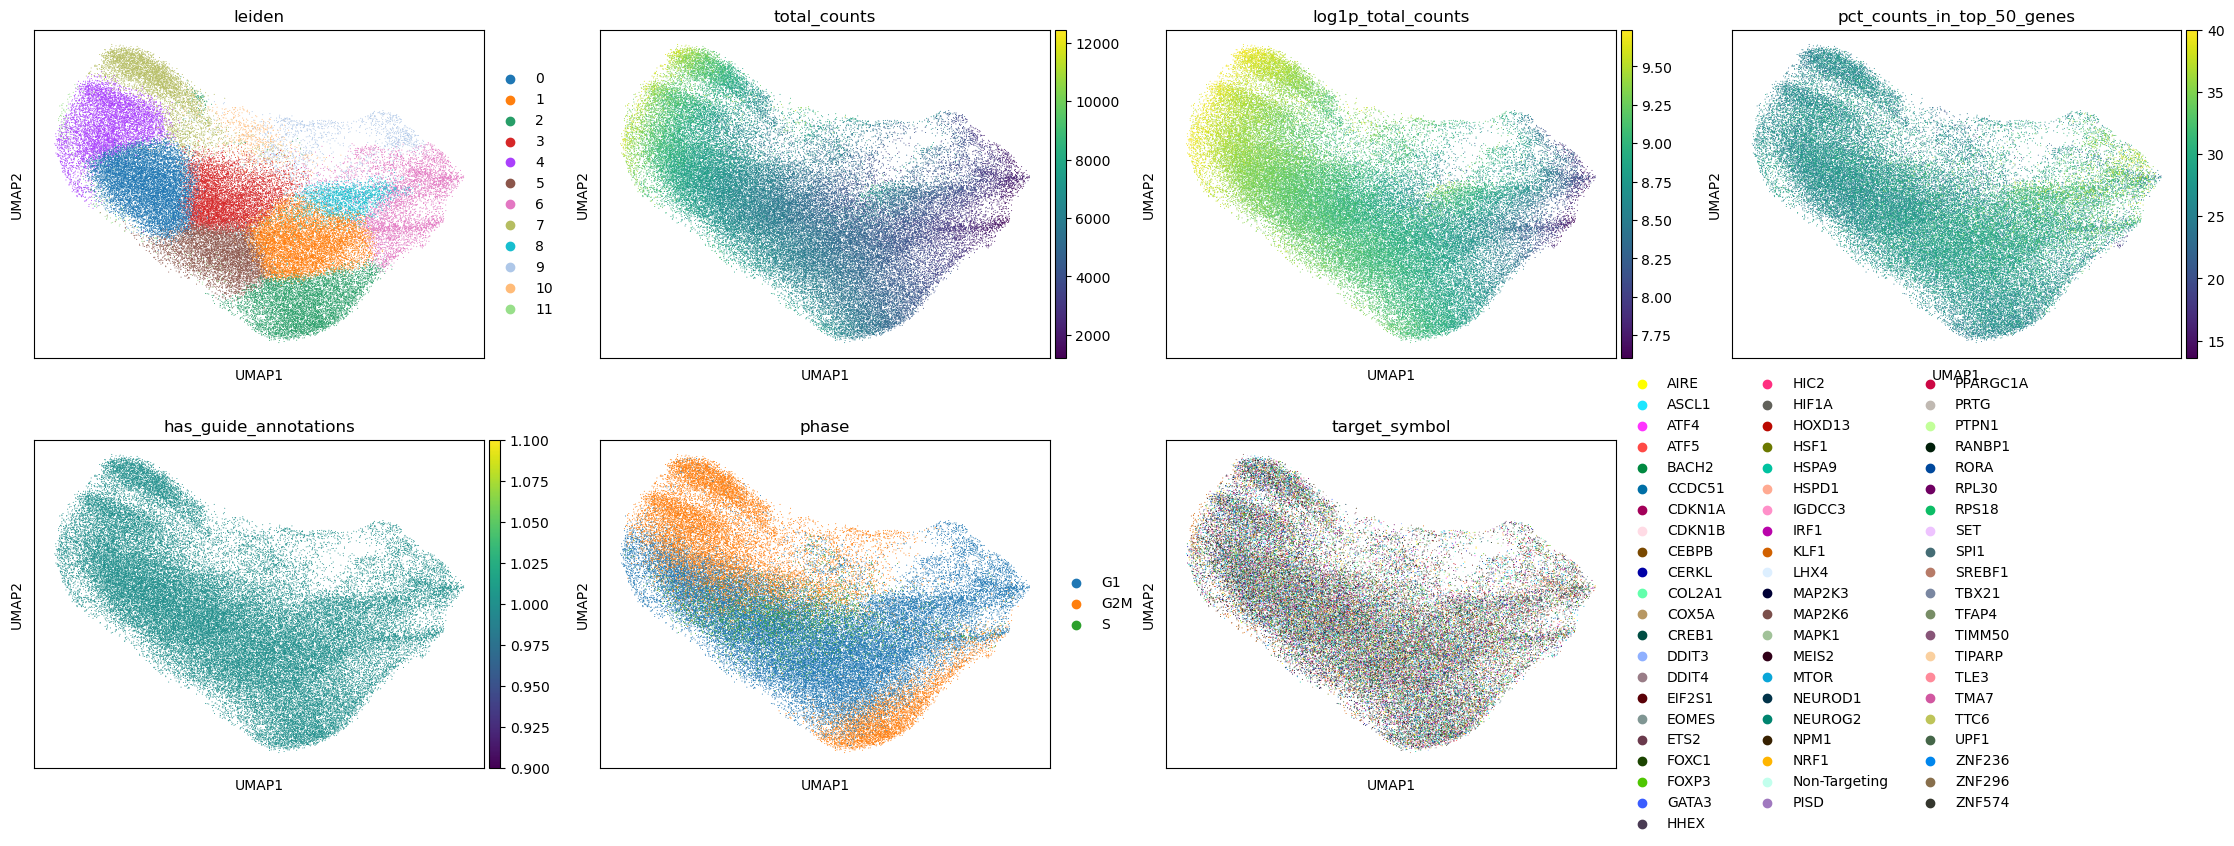

In [43]:
sc.pl.umap(expression_quantified, color = [
    # "PTPRC",
    "leiden", 
    'total_counts', 
    'log1p_total_counts',
    'pct_counts_in_top_50_genes', 
    'has_guide_annotations',
    "phase",
    "target_symbol",
])

### 3.1 Run the code and describe the results.

The UMAP shows a roughly unimodal distribution a lot of variation driven by cell cycle and read depth. Cells do not obviously cluster by which gene was overexpressed. This suggests that most of these perturbations do not cause extensive reprogramming of cell state.
 